In [1]:
#PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#Numpy
import numpy as np

#Dataset
import torch.utils.data as utils

#Graphs
import matplotlib.pyplot as plt

#For paths
import sys
import os
import glob

#imread and resize
from skimage import io, transform

#split dataset
from sklearn.model_selection import train_test_split

#Timestamp
import datetime

#PyTorch Models
path = os.path.join(os.path.dirname(os.path.abspath('__file__')), "models")
sys.path.append(path)
from models import *

In [2]:
root_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), "kinect_leap_dataset", "acquisitions")
p_id = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10", "P11", "P12", "P13", "P14"]
g_id = ["G1", "G2", "G3", "G4", "G5", "G6", "G7", "G8", "G9", "G10"]

In [3]:
print(os.path.join(root_path, "P1", "G1"))
files = glob.glob(os.path.join(root_path, "P1", "G1", "*rgb.png"))
print(files)
print(len(files))

C:\Users\Bilal\git\gesture_recog_leap\kinect_leap_dataset\acquisitions\P1\G1
['C:\\Users\\Bilal\\git\\gesture_recog_leap\\kinect_leap_dataset\\acquisitions\\P1\\G1\\10_rgb.png', 'C:\\Users\\Bilal\\git\\gesture_recog_leap\\kinect_leap_dataset\\acquisitions\\P1\\G1\\1_rgb.png', 'C:\\Users\\Bilal\\git\\gesture_recog_leap\\kinect_leap_dataset\\acquisitions\\P1\\G1\\2_rgb.png', 'C:\\Users\\Bilal\\git\\gesture_recog_leap\\kinect_leap_dataset\\acquisitions\\P1\\G1\\3_rgb.png', 'C:\\Users\\Bilal\\git\\gesture_recog_leap\\kinect_leap_dataset\\acquisitions\\P1\\G1\\4_rgb.png', 'C:\\Users\\Bilal\\git\\gesture_recog_leap\\kinect_leap_dataset\\acquisitions\\P1\\G1\\5_rgb.png', 'C:\\Users\\Bilal\\git\\gesture_recog_leap\\kinect_leap_dataset\\acquisitions\\P1\\G1\\6_rgb.png', 'C:\\Users\\Bilal\\git\\gesture_recog_leap\\kinect_leap_dataset\\acquisitions\\P1\\G1\\7_rgb.png', 'C:\\Users\\Bilal\\git\\gesture_recog_leap\\kinect_leap_dataset\\acquisitions\\P1\\G1\\8_rgb.png', 'C:\\Users\\Bilal\\git\\gestur

In [4]:
dataset = []
labels = []

for p in p_id:
    for g in g_id:
        path = os.path.join(root_path, p, g)
        image_names = glob.glob(os.path.join(path, "*rgb.png"))
        for img_path in image_names:
            img = io.imread(img_path)
            
            #img = transform.rescale(img, 1.0 / 20.0)
            img = transform.resize(img, (32, 32))
            #48x64x3 -> 3x48x64
            img = np.moveaxis(img, [0, 1, 2], [1, 2, 0])
            
            dataset.append(img)
            
            #label 10 will be 0
            tmp = np.zeros(10)
            tmp[int(g[-1])] = 1
            labels.append(tmp)
            #labels.append(int(g[-1]))

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
dataset = np.array(dataset).astype(float)
labels = np.array(labels).astype(float)

In [6]:
X_train, X_test_val, y_train, y_test_val = train_test_split(dataset, labels, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5)

In [7]:
dataset = torch.from_numpy(dataset).float()
labels = torch.from_numpy(labels).float()

In [8]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

In [9]:
my_dataset = utils.TensorDataset(dataset, labels) # create your dataset
my_dataloader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

In [10]:
my_dataset = utils.TensorDataset(X_train, y_train) # create your dataset
train_loader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

my_dataset = utils.TensorDataset(X_val, y_val) # create your dataset
val_loader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

my_dataset = utils.TensorDataset(X_test, y_test) # create your dataset
test_loader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

In [11]:
model = ResNet152()
#Target has to be LongSensor for CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

#criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=5e-4)

#optimizer = optim.SGD(resnet.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)

In [12]:
def test():
    net = ResNet152()
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())
test()

torch.Size([2, 10])


In [13]:
train_loss_history = []
train_acc_history = []
val_acc_history = []
val_loss_history = []
num_epochs = 200
iter_per_epoch = len(train_loader)
#224 lines -> 112 val output for log_nth=10000
#1120000 iter
log_nth = 10

if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):  # loop over the dataset multiple times
    for i, (inputs, targets) in enumerate(train_loader, 1):
        #inputs, targets = Variable(inputs.float()), Variable(targets.float())
        #for CrossEntropyLoss
        inputs, targets = Variable(inputs), Variable(targets)
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        #loss = criterion(outputs, targets)
        #for CrossEntropyLoss
        loss = criterion(outputs, torch.max(targets, 1)[1])
        
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss_history.append(loss.data.cpu().numpy())
        if log_nth and i % log_nth == 0:
            last_log_nth_losses = train_loss_history[-log_nth:]
            train_loss = np.mean(last_log_nth_losses)
            print('[Iteration %d/%d] TRAIN loss: %.3f' % \
                        (i + epoch * iter_per_epoch,
                         iter_per_epoch * num_epochs,
                         train_loss))
            
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)

    train_acc = np.mean((preds == target_indices).data.cpu().numpy())
    train_acc_history.append(train_acc)
    if log_nth:
        print('[Epoch %d/%d] TRAIN acc/loss: %.3f/%.3f' % (epoch + 1,
                                                            num_epochs,
                                                            train_acc,
                                                            loss))
        '''_, preds = torch.max(outputs, 1)

        # Only allow images/pixels with label >= 0 e.g. for segmentation
        targets_mask = labels >= 0
        train_acc = np.mean((preds == targets)[targets_mask].data.cpu().numpy())
        train_acc_history.append(train_acc)
        if log_nth:
            print('[Epoch %d/%d] TRAIN acc/loss: %.3f/%.3f' % (epoch + 1,
                                                                   num_epochs,
                                                                   train_acc,
                                                                   train_loss))'''
        
    # VALIDATION
    val_losses = []
    val_scores = []
    model.eval()
    for inputs, targets in val_loader:
        inputs, targets = Variable(inputs), Variable(targets)
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model.forward(inputs)
        
        #loss = criterion(outputs, targets)
        
        #for CrossEntropyLoss
        loss = criterion(outputs, torch.max(targets, 1)[1])
        
        val_losses.append(loss.data.cpu().numpy())

        _, preds = torch.max(outputs, 1)
        _, target_indices = torch.max(targets, 1)

        scores = np.mean((preds == target_indices).data.cpu().numpy())
        val_scores.append(scores)

    model.train()
    val_acc, val_loss = np.mean(val_scores), np.mean(val_losses)
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    if log_nth:
        print('[Epoch %d/%d] VAL   acc/loss: %.3f/%.3f' % (epoch + 1,
                                                            num_epochs,
                                                            val_acc,
                                                            val_loss))

print('Finished Training')

[Iteration 10/22400] TRAIN loss: 2.328
[Iteration 20/22400] TRAIN loss: 2.324
[Iteration 30/22400] TRAIN loss: 2.328
[Iteration 40/22400] TRAIN loss: 2.352
[Iteration 50/22400] TRAIN loss: 2.319
[Iteration 60/22400] TRAIN loss: 2.306
[Iteration 70/22400] TRAIN loss: 2.317
[Iteration 80/22400] TRAIN loss: 2.320
[Iteration 90/22400] TRAIN loss: 2.326
[Iteration 100/22400] TRAIN loss: 2.327
[Iteration 110/22400] TRAIN loss: 2.333
[Epoch 1/200] TRAIN acc/loss: 0.100/2.312
[Epoch 1/200] VAL   acc/loss: 0.086/2.316
[Iteration 122/22400] TRAIN loss: 2.291
[Iteration 132/22400] TRAIN loss: 2.292
[Iteration 142/22400] TRAIN loss: 2.309
[Iteration 152/22400] TRAIN loss: 2.309
[Iteration 162/22400] TRAIN loss: 2.324
[Iteration 172/22400] TRAIN loss: 2.309
[Iteration 182/22400] TRAIN loss: 2.331
[Iteration 192/22400] TRAIN loss: 2.323
[Iteration 202/22400] TRAIN loss: 2.303
[Iteration 212/22400] TRAIN loss: 2.327
[Iteration 222/22400] TRAIN loss: 2.312
[Epoch 2/200] TRAIN acc/loss: 0.000/2.321
[Ep

[Iteration 1760/22400] TRAIN loss: 2.242
[Iteration 1770/22400] TRAIN loss: 2.229
[Iteration 1780/22400] TRAIN loss: 2.238
[Iteration 1790/22400] TRAIN loss: 2.241
[Epoch 16/200] TRAIN acc/loss: 0.100/2.233
[Epoch 16/200] VAL   acc/loss: 0.193/2.195
[Iteration 1802/22400] TRAIN loss: 2.244
[Iteration 1812/22400] TRAIN loss: 2.234
[Iteration 1822/22400] TRAIN loss: 2.251
[Iteration 1832/22400] TRAIN loss: 2.239
[Iteration 1842/22400] TRAIN loss: 2.235
[Iteration 1852/22400] TRAIN loss: 2.230
[Iteration 1862/22400] TRAIN loss: 2.204
[Iteration 1872/22400] TRAIN loss: 2.214
[Iteration 1882/22400] TRAIN loss: 2.209
[Iteration 1892/22400] TRAIN loss: 2.238
[Iteration 1902/22400] TRAIN loss: 2.252
[Epoch 17/200] TRAIN acc/loss: 0.400/2.142
[Epoch 17/200] VAL   acc/loss: 0.207/2.206
[Iteration 1914/22400] TRAIN loss: 2.249
[Iteration 1924/22400] TRAIN loss: 2.238
[Iteration 1934/22400] TRAIN loss: 2.224
[Iteration 1944/22400] TRAIN loss: 2.203
[Iteration 1954/22400] TRAIN loss: 2.254
[Iterati

[Epoch 31/200] TRAIN acc/loss: 0.400/1.640
[Epoch 31/200] VAL   acc/loss: 0.250/2.014
[Iteration 3482/22400] TRAIN loss: 1.746
[Iteration 3492/22400] TRAIN loss: 1.754
[Iteration 3502/22400] TRAIN loss: 1.856
[Iteration 3512/22400] TRAIN loss: 1.772
[Iteration 3522/22400] TRAIN loss: 1.838
[Iteration 3532/22400] TRAIN loss: 1.682
[Iteration 3542/22400] TRAIN loss: 1.834
[Iteration 3552/22400] TRAIN loss: 1.870
[Iteration 3562/22400] TRAIN loss: 1.877
[Iteration 3572/22400] TRAIN loss: 1.858
[Iteration 3582/22400] TRAIN loss: 1.857
[Epoch 32/200] TRAIN acc/loss: 0.200/1.817
[Epoch 32/200] VAL   acc/loss: 0.257/1.940
[Iteration 3594/22400] TRAIN loss: 1.801
[Iteration 3604/22400] TRAIN loss: 1.701
[Iteration 3614/22400] TRAIN loss: 1.698
[Iteration 3624/22400] TRAIN loss: 1.758
[Iteration 3634/22400] TRAIN loss: 1.815
[Iteration 3644/22400] TRAIN loss: 1.803
[Iteration 3654/22400] TRAIN loss: 1.785
[Iteration 3664/22400] TRAIN loss: 1.767
[Iteration 3674/22400] TRAIN loss: 1.813
[Iterati

[Iteration 5182/22400] TRAIN loss: 1.131
[Iteration 5192/22400] TRAIN loss: 1.147
[Iteration 5202/22400] TRAIN loss: 1.140
[Iteration 5212/22400] TRAIN loss: 1.083
[Iteration 5222/22400] TRAIN loss: 1.170
[Iteration 5232/22400] TRAIN loss: 1.202
[Iteration 5242/22400] TRAIN loss: 1.114
[Iteration 5252/22400] TRAIN loss: 1.231
[Iteration 5262/22400] TRAIN loss: 1.335
[Epoch 47/200] TRAIN acc/loss: 0.800/0.946
[Epoch 47/200] VAL   acc/loss: 0.400/1.705
[Iteration 5274/22400] TRAIN loss: 1.081
[Iteration 5284/22400] TRAIN loss: 0.996
[Iteration 5294/22400] TRAIN loss: 0.928
[Iteration 5304/22400] TRAIN loss: 1.106
[Iteration 5314/22400] TRAIN loss: 0.967
[Iteration 5324/22400] TRAIN loss: 1.042
[Iteration 5334/22400] TRAIN loss: 1.169
[Iteration 5344/22400] TRAIN loss: 1.121
[Iteration 5354/22400] TRAIN loss: 1.066
[Iteration 5364/22400] TRAIN loss: 1.076
[Iteration 5374/22400] TRAIN loss: 1.098
[Epoch 48/200] TRAIN acc/loss: 0.500/1.292
[Epoch 48/200] VAL   acc/loss: 0.457/1.501
[Iterati

[Iteration 6902/22400] TRAIN loss: 0.646
[Iteration 6912/22400] TRAIN loss: 0.911
[Iteration 6922/22400] TRAIN loss: 0.651
[Iteration 6932/22400] TRAIN loss: 0.789
[Iteration 6942/22400] TRAIN loss: 0.657
[Epoch 62/200] TRAIN acc/loss: 0.800/0.534
[Epoch 62/200] VAL   acc/loss: 0.543/1.427
[Iteration 6954/22400] TRAIN loss: 0.679
[Iteration 6964/22400] TRAIN loss: 0.744
[Iteration 6974/22400] TRAIN loss: 0.743
[Iteration 6984/22400] TRAIN loss: 0.575
[Iteration 6994/22400] TRAIN loss: 0.608
[Iteration 7004/22400] TRAIN loss: 0.612
[Iteration 7014/22400] TRAIN loss: 0.623
[Iteration 7024/22400] TRAIN loss: 0.707
[Iteration 7034/22400] TRAIN loss: 0.787
[Iteration 7044/22400] TRAIN loss: 0.740
[Iteration 7054/22400] TRAIN loss: 0.794
[Epoch 63/200] TRAIN acc/loss: 0.700/0.929
[Epoch 63/200] VAL   acc/loss: 0.586/1.253
[Iteration 7066/22400] TRAIN loss: 0.531
[Iteration 7076/22400] TRAIN loss: 0.558
[Iteration 7086/22400] TRAIN loss: 0.616
[Iteration 7096/22400] TRAIN loss: 0.729
[Iterati

[Iteration 8622/22400] TRAIN loss: 0.417
[Epoch 77/200] TRAIN acc/loss: 0.500/1.170
[Epoch 77/200] VAL   acc/loss: 0.686/1.189
[Iteration 8634/22400] TRAIN loss: 0.511
[Iteration 8644/22400] TRAIN loss: 0.408
[Iteration 8654/22400] TRAIN loss: 0.629
[Iteration 8664/22400] TRAIN loss: 0.327
[Iteration 8674/22400] TRAIN loss: 0.283
[Iteration 8684/22400] TRAIN loss: 0.537
[Iteration 8694/22400] TRAIN loss: 0.437
[Iteration 8704/22400] TRAIN loss: 0.359
[Iteration 8714/22400] TRAIN loss: 0.441
[Iteration 8724/22400] TRAIN loss: 0.381
[Iteration 8734/22400] TRAIN loss: 0.402
[Epoch 78/200] TRAIN acc/loss: 0.800/0.393
[Epoch 78/200] VAL   acc/loss: 0.686/1.095
[Iteration 8746/22400] TRAIN loss: 0.261
[Iteration 8756/22400] TRAIN loss: 0.268
[Iteration 8766/22400] TRAIN loss: 0.272
[Iteration 8776/22400] TRAIN loss: 0.387
[Iteration 8786/22400] TRAIN loss: 0.360
[Iteration 8796/22400] TRAIN loss: 0.402
[Iteration 8806/22400] TRAIN loss: 0.399
[Iteration 8816/22400] TRAIN loss: 0.448
[Iterati

[Iteration 10314/22400] TRAIN loss: 0.155
[Iteration 10324/22400] TRAIN loss: 0.264
[Iteration 10334/22400] TRAIN loss: 0.337
[Iteration 10344/22400] TRAIN loss: 0.274
[Iteration 10354/22400] TRAIN loss: 0.324
[Iteration 10364/22400] TRAIN loss: 0.209
[Iteration 10374/22400] TRAIN loss: 0.375
[Iteration 10384/22400] TRAIN loss: 0.177
[Iteration 10394/22400] TRAIN loss: 0.307
[Iteration 10404/22400] TRAIN loss: 0.312
[Iteration 10414/22400] TRAIN loss: 0.152
[Epoch 93/200] TRAIN acc/loss: 0.900/0.572
[Epoch 93/200] VAL   acc/loss: 0.636/1.176
[Iteration 10426/22400] TRAIN loss: 0.329
[Iteration 10436/22400] TRAIN loss: 0.215
[Iteration 10446/22400] TRAIN loss: 0.339
[Iteration 10456/22400] TRAIN loss: 0.192
[Iteration 10466/22400] TRAIN loss: 0.363
[Iteration 10476/22400] TRAIN loss: 0.231
[Iteration 10486/22400] TRAIN loss: 0.202
[Iteration 10496/22400] TRAIN loss: 0.295
[Iteration 10506/22400] TRAIN loss: 0.261
[Iteration 10516/22400] TRAIN loss: 0.172
[Iteration 10526/22400] TRAIN lo

[Iteration 11994/22400] TRAIN loss: 0.099
[Iteration 12004/22400] TRAIN loss: 0.195
[Iteration 12014/22400] TRAIN loss: 0.154
[Iteration 12024/22400] TRAIN loss: 0.106
[Iteration 12034/22400] TRAIN loss: 0.137
[Iteration 12044/22400] TRAIN loss: 0.342
[Iteration 12054/22400] TRAIN loss: 0.140
[Iteration 12064/22400] TRAIN loss: 0.186
[Iteration 12074/22400] TRAIN loss: 0.216
[Iteration 12084/22400] TRAIN loss: 0.096
[Iteration 12094/22400] TRAIN loss: 0.144
[Epoch 108/200] TRAIN acc/loss: 0.900/0.468
[Epoch 108/200] VAL   acc/loss: 0.679/1.143
[Iteration 12106/22400] TRAIN loss: 0.103
[Iteration 12116/22400] TRAIN loss: 0.161
[Iteration 12126/22400] TRAIN loss: 0.125
[Iteration 12136/22400] TRAIN loss: 0.136
[Iteration 12146/22400] TRAIN loss: 0.171
[Iteration 12156/22400] TRAIN loss: 0.191
[Iteration 12166/22400] TRAIN loss: 0.155
[Iteration 12176/22400] TRAIN loss: 0.051
[Iteration 12186/22400] TRAIN loss: 0.242
[Iteration 12196/22400] TRAIN loss: 0.174
[Iteration 12206/22400] TRAIN 

[Epoch 122/200] VAL   acc/loss: 0.693/1.124
[Iteration 13674/22400] TRAIN loss: 0.093
[Iteration 13684/22400] TRAIN loss: 0.152
[Iteration 13694/22400] TRAIN loss: 0.086
[Iteration 13704/22400] TRAIN loss: 0.208
[Iteration 13714/22400] TRAIN loss: 0.056
[Iteration 13724/22400] TRAIN loss: 0.073
[Iteration 13734/22400] TRAIN loss: 0.103
[Iteration 13744/22400] TRAIN loss: 0.074
[Iteration 13754/22400] TRAIN loss: 0.104
[Iteration 13764/22400] TRAIN loss: 0.161
[Iteration 13774/22400] TRAIN loss: 0.180
[Epoch 123/200] TRAIN acc/loss: 0.800/0.408
[Epoch 123/200] VAL   acc/loss: 0.729/1.055
[Iteration 13786/22400] TRAIN loss: 0.199
[Iteration 13796/22400] TRAIN loss: 0.097
[Iteration 13806/22400] TRAIN loss: 0.245
[Iteration 13816/22400] TRAIN loss: 0.224
[Iteration 13826/22400] TRAIN loss: 0.258
[Iteration 13836/22400] TRAIN loss: 0.131
[Iteration 13846/22400] TRAIN loss: 0.125
[Iteration 13856/22400] TRAIN loss: 0.251
[Iteration 13866/22400] TRAIN loss: 0.130
[Iteration 13876/22400] TRAI

[Epoch 137/200] TRAIN acc/loss: 1.000/0.038
[Epoch 137/200] VAL   acc/loss: 0.686/1.033
[Iteration 15354/22400] TRAIN loss: 0.094
[Iteration 15364/22400] TRAIN loss: 0.070
[Iteration 15374/22400] TRAIN loss: 0.075
[Iteration 15384/22400] TRAIN loss: 0.103
[Iteration 15394/22400] TRAIN loss: 0.177
[Iteration 15404/22400] TRAIN loss: 0.128
[Iteration 15414/22400] TRAIN loss: 0.156
[Iteration 15424/22400] TRAIN loss: 0.111
[Iteration 15434/22400] TRAIN loss: 0.121
[Iteration 15444/22400] TRAIN loss: 0.122
[Iteration 15454/22400] TRAIN loss: 0.126
[Epoch 138/200] TRAIN acc/loss: 0.900/0.210
[Epoch 138/200] VAL   acc/loss: 0.721/1.059
[Iteration 15466/22400] TRAIN loss: 0.101
[Iteration 15476/22400] TRAIN loss: 0.075
[Iteration 15486/22400] TRAIN loss: 0.181
[Iteration 15496/22400] TRAIN loss: 0.129
[Iteration 15506/22400] TRAIN loss: 0.094
[Iteration 15516/22400] TRAIN loss: 0.119
[Iteration 15526/22400] TRAIN loss: 0.100
[Iteration 15536/22400] TRAIN loss: 0.168
[Iteration 15546/22400] TR

[Iteration 17022/22400] TRAIN loss: 0.068
[Epoch 152/200] TRAIN acc/loss: 0.900/0.271
[Epoch 152/200] VAL   acc/loss: 0.764/1.069
[Iteration 17034/22400] TRAIN loss: 0.018
[Iteration 17044/22400] TRAIN loss: 0.146
[Iteration 17054/22400] TRAIN loss: 0.230
[Iteration 17064/22400] TRAIN loss: 0.114
[Iteration 17074/22400] TRAIN loss: 0.091
[Iteration 17084/22400] TRAIN loss: 0.116
[Iteration 17094/22400] TRAIN loss: 0.126
[Iteration 17104/22400] TRAIN loss: 0.126
[Iteration 17114/22400] TRAIN loss: 0.047
[Iteration 17124/22400] TRAIN loss: 0.129
[Iteration 17134/22400] TRAIN loss: 0.068
[Epoch 153/200] TRAIN acc/loss: 1.000/0.023
[Epoch 153/200] VAL   acc/loss: 0.736/1.170
[Iteration 17146/22400] TRAIN loss: 0.224
[Iteration 17156/22400] TRAIN loss: 0.147
[Iteration 17166/22400] TRAIN loss: 0.093
[Iteration 17176/22400] TRAIN loss: 0.036
[Iteration 17186/22400] TRAIN loss: 0.148
[Iteration 17196/22400] TRAIN loss: 0.023
[Iteration 17206/22400] TRAIN loss: 0.056
[Iteration 17216/22400] TR

[Iteration 18692/22400] TRAIN loss: 0.145
[Iteration 18702/22400] TRAIN loss: 0.044
[Epoch 167/200] TRAIN acc/loss: 1.000/0.094
[Epoch 167/200] VAL   acc/loss: 0.793/0.964
[Iteration 18714/22400] TRAIN loss: 0.099
[Iteration 18724/22400] TRAIN loss: 0.133
[Iteration 18734/22400] TRAIN loss: 0.031
[Iteration 18744/22400] TRAIN loss: 0.103
[Iteration 18754/22400] TRAIN loss: 0.025
[Iteration 18764/22400] TRAIN loss: 0.039
[Iteration 18774/22400] TRAIN loss: 0.076
[Iteration 18784/22400] TRAIN loss: 0.082
[Iteration 18794/22400] TRAIN loss: 0.037
[Iteration 18804/22400] TRAIN loss: 0.042
[Iteration 18814/22400] TRAIN loss: 0.074
[Epoch 168/200] TRAIN acc/loss: 1.000/0.015
[Epoch 168/200] VAL   acc/loss: 0.757/1.014
[Iteration 18826/22400] TRAIN loss: 0.078
[Iteration 18836/22400] TRAIN loss: 0.049
[Iteration 18846/22400] TRAIN loss: 0.076
[Iteration 18856/22400] TRAIN loss: 0.067
[Iteration 18866/22400] TRAIN loss: 0.068
[Iteration 18876/22400] TRAIN loss: 0.035
[Iteration 18886/22400] TR

[Iteration 20362/22400] TRAIN loss: 0.059
[Iteration 20372/22400] TRAIN loss: 0.070
[Iteration 20382/22400] TRAIN loss: 0.108
[Epoch 182/200] TRAIN acc/loss: 0.900/0.125
[Epoch 182/200] VAL   acc/loss: 0.793/0.922
[Iteration 20394/22400] TRAIN loss: 0.062
[Iteration 20404/22400] TRAIN loss: 0.104
[Iteration 20414/22400] TRAIN loss: 0.022
[Iteration 20424/22400] TRAIN loss: 0.121
[Iteration 20434/22400] TRAIN loss: 0.076
[Iteration 20444/22400] TRAIN loss: 0.067
[Iteration 20454/22400] TRAIN loss: 0.055
[Iteration 20464/22400] TRAIN loss: 0.069
[Iteration 20474/22400] TRAIN loss: 0.135
[Iteration 20484/22400] TRAIN loss: 0.066
[Iteration 20494/22400] TRAIN loss: 0.108
[Epoch 183/200] TRAIN acc/loss: 0.900/0.162
[Epoch 183/200] VAL   acc/loss: 0.829/0.850
[Iteration 20506/22400] TRAIN loss: 0.037
[Iteration 20516/22400] TRAIN loss: 0.036
[Iteration 20526/22400] TRAIN loss: 0.089
[Iteration 20536/22400] TRAIN loss: 0.073
[Iteration 20546/22400] TRAIN loss: 0.043
[Iteration 20556/22400] TR

[Iteration 22032/22400] TRAIN loss: 0.087
[Iteration 22042/22400] TRAIN loss: 0.048
[Iteration 22052/22400] TRAIN loss: 0.107
[Iteration 22062/22400] TRAIN loss: 0.058
[Epoch 197/200] TRAIN acc/loss: 1.000/0.002
[Epoch 197/200] VAL   acc/loss: 0.800/0.843
[Iteration 22074/22400] TRAIN loss: 0.069
[Iteration 22084/22400] TRAIN loss: 0.069
[Iteration 22094/22400] TRAIN loss: 0.033
[Iteration 22104/22400] TRAIN loss: 0.037
[Iteration 22114/22400] TRAIN loss: 0.087
[Iteration 22124/22400] TRAIN loss: 0.028
[Iteration 22134/22400] TRAIN loss: 0.070
[Iteration 22144/22400] TRAIN loss: 0.057
[Iteration 22154/22400] TRAIN loss: 0.043
[Iteration 22164/22400] TRAIN loss: 0.031
[Iteration 22174/22400] TRAIN loss: 0.027
[Epoch 198/200] TRAIN acc/loss: 1.000/0.006
[Epoch 198/200] VAL   acc/loss: 0.807/0.928
[Iteration 22186/22400] TRAIN loss: 0.052
[Iteration 22196/22400] TRAIN loss: 0.036
[Iteration 22206/22400] TRAIN loss: 0.082
[Iteration 22216/22400] TRAIN loss: 0.038
[Iteration 22226/22400] TR

In [14]:
params = list(model.parameters())

In [15]:
#https://pytorch.org/docs/stable/notes/serialization.html#recommend-saving-models
currentDT = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = os.path.join(os.path.dirname(os.path.abspath('__file__')), "saved_models", "resnet_rgb_" + str(num_epochs) + "_" + currentDT + ".model")
torch.save(model.state_dict(), path)

#Loading
#model = VGG('VGG16')
#model.load_state_dict(torch.load(path))

In [16]:
#model = ResNet152()
#if torch.cuda.is_available():
#    model = model.cuda()

#path = "C:/Users/Bilal/git/gesture_recog_leap/saved_models/resnet_rgb_100_2018-07-04_06-59-19.model"
#model.load_state_dict(torch.load(path))

In [17]:
scores = []
for inputs, target in test_loader:
    inputs, targets = Variable(inputs), Variable(target)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)
    scores.extend((preds == target_indices).data.cpu().numpy())
    
print('Test set accuracy: %f' % np.mean(scores))

RuntimeError: cuda runtime error (2) : out of memory at c:\programdata\miniconda3\conda-bld\pytorch_1524543037166\work\aten\src\thc\generic/THCStorage.cu:58

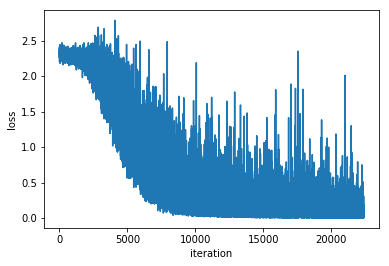

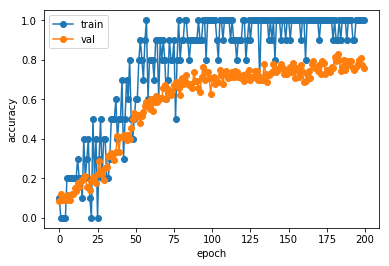

In [24]:
plt.plot(train_loss_history, '-')
#plt.plot(val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [19]:
for inputs, target in test_loader:
    inputs, targets = Variable(inputs), Variable(target)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)
    scores.extend((preds == target_indices).data.cpu().numpy())

RuntimeError: cuda runtime error (2) : out of memory at c:\programdata\miniconda3\conda-bld\pytorch_1524543037166\work\aten\src\thc\generic/THCStorage.cu:58

In [20]:
for inputs, target in test_loader:
    inputs, targets = Variable(inputs), Variable(target)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)
    
    numpy_inputs = inputs.data.cpu().numpy()
    numpy_outputs = outputs.data.cpu().numpy()
    numpy_targets = targets.data.cpu().numpy()
    
    img = numpy_inputs[0]
    img = img[0, :, :]
    plt.imshow(img)
    plt.title("Predicted: "+str(preds[0].item()) + " Target: "+str(target_indices[0].item()))
    plt.show()
    #currentDT = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    #path = "images/img_" + currentDT + ".png"
    #plt.imsave(path, img.astype(float))

RuntimeError: cuda runtime error (2) : out of memory at c:\programdata\miniconda3\conda-bld\pytorch_1524543037166\work\aten\src\thc\generic/THCStorage.cu:58